In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Data Exploration

In [2]:
data_raw = pd.read_csv("Offset robot.csv",skiprows=5)

## Data Explanation

Coordinates/distances are in mm, angles are in degrees.

The angles reported by our robot seem very inconsistent and we were unable to make much sense of them.

The original data is attached as a csv

In [3]:
data_raw.columns.values

array(['ccp_x', 'ccp_y', 'ccp_z', 'ccp_rx', 'ccp_ry', 'ccp_rz', 'tcp_x',
       'tcp_y', 'tcp_z', 'tcp_rx', 'tcp_ry', 'tcp_rz', 'isp_x', 'isp_y',
       'isp_z', 'isp_rx', 'isp_ry', 'isp_rz', 'fsp_x', 'fsp_y', 'fsp_z',
       'fsp_rx', 'fsp_ry', 'fsp_rz', 'ad_x', 'ad_y', 'ad_z', 'ad_rx',
       'ad_ry', 'ad_rz', 'ed_x', 'ed_y', 'ed_z', 'ed_rx', 'ed_ry',
       'ed_rz', 'os_x', 'os_y', 'os_z', 'os_rx', 'os_ry', 'os_rz'],
      dtype=object)

| data_column | description |
|----- | -- |
| ccp | initial starting location in robot base coordinates (location where image is taken)|
| tcp | ccp shifted by camera offset (from tool center point) |
| isp | in-socket-point - robot base location when plug is completely inserted in socket |
| fsp | front-of-socket-point - robot base location when plug is directly in front of socket (angles adjusted) |
| ad | actual distance between tcp and fsp |
| ed | camera/client estimate of distance |
| os | offset (ed - ad)|

#### Description of data acquisition:
- Move robot to ccp
    - take image
    - save estimated distance (ed)
    - calculate actual distance: fsp - ccp - camera offset
    - calculate offset (difference between estimate and actual distance)

#### camera offset
x = -82mm
y = 6mm
z = 55.5mm
rx = 0°
ry = 0°
rz = 0°

In [4]:
data_raw.sample(20)

,ccp_x,ccp_y,ccp_z,ccp_rx,ccp_ry,ccp_rz,tcp_x,tcp_y,tcp_z,tcp_rx,...,ed_z,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz
17,639.927612,108.081703,449.817657,14.820652,-179.975479,14.801626,557.9,114.1,505.3,14.8,...,23.0,0.968299,7.563043,2.881978,-14.0,15.2,11.7,-162.9,-343.1,-161.2
22,639.931152,103.075081,449.829498,14.697850,-179.976288,14.679799,557.9,109.1,505.3,14.7,...,23.1,0.905273,7.402615,2.624147,-13.6,15.2,11.8,-163.1,-343.3,-161.5
448,588.970886,30.005304,449.933563,20.207365,-179.996323,20.206633,507.0,36.0,505.4,20.2,...,24.9,0.853707,5.884277,1.844924,-14.2,14.8,13.7,-157.6,-344.8,-156.8
354,494.972687,30.002413,449.954864,27.574722,-179.996918,27.574272,413.0,36.0,505.5,27.6,...,28.3,0.888085,5.357155,1.770440,-17.2,16.6,17.2,-150.2,-345.3,-149.5
566,706.982910,30.004852,449.941223,45.551620,-179.998199,45.551010,625.0,36.0,505.4,45.6,...,21.4,0.813600,6.789550,1.988164,-9.3,12.7,10.3,-132.3,-343.9,-131.3
574,714.966736,29.989775,449.905029,18.908798,-179.996094,18.912035,633.0,36.0,505.4,18.9,...,21.4,0.807870,6.995815,1.506879,-8.9,12.5,10.2,-159.0,-343.7,-158.4
376,516.960510,30.002274,449.926117,17.475527,-179.995331,17.475285,435.0,36.0,505.4,17.5,...,27.7,0.876625,5.569150,1.764710,-17.1,16.2,16.5,-160.3,-345.1,-159.6
378,518.965088,30.001690,449.929474,18.311245,-179.995529,18.311058,437.0,36.0,505.4,18.3,...,27.6,0.962569,5.328507,3.191375,-16.4,16.1,16.4,-159.4,-345.3,-157.3
491,631.977661,30.005852,449.946564,36.128944,-179.997818,36.128216,550.0,36.0,505.4,36.1,...,24.4,0.842248,5.855629,1.999623,-12.1,14.1,13.3,-141.7,-344.8,-140.7
374,514.968994,30.001989,449.945984,24.928530,-179.996628,24.928350,433.0,36.0,505.4,24.9,...,27.6,0.893814,5.597798,1.140186,-16.9,16.2,16.5,-152.9,-345.1,-152.8


In [5]:
diff_df = data_raw.iloc[:,24:]
diff_df

,ad_x,ad_y,ad_z,ad_rx,ad_ry,ad_rz,ed_x,ed_y,ed_z,ed_rx,ed_ry,ed_rz,os_x,os_y,os_z,os_rx,os_ry,os_rz
0,548.5,-148.2,11.2,163.1,350.7,163.3,534.7,-132.8,23.3,0.991217,7.608880,2.813223,-13.8,15.4,12.1,-162.1,-343.1,-160.5
1,548.5,-147.2,11.2,163.0,350.7,163.2,534.6,-131.8,23.3,0.979758,7.522936,2.773116,-13.9,15.4,12.1,-162.1,-343.1,-160.4
2,548.6,-146.2,11.3,163.5,350.7,163.7,534.6,-130.7,23.2,0.911003,7.339589,2.893437,-14.0,15.5,11.9,-162.6,-343.3,-160.8
3,548.6,-145.2,11.3,163.6,350.7,163.8,534.6,-129.7,23.2,0.956840,7.608880,2.578310,-14.0,15.5,11.9,-162.7,-343.0,-161.2
4,548.5,-144.2,11.3,163.6,350.7,163.8,534.4,-128.6,23.1,0.939651,7.500018,2.641335,-14.1,15.6,11.8,-162.7,-343.2,-161.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,436.5,-53.1,11.2,155.6,350.7,155.8,429.2,-41.3,20.4,0.825059,7.207809,1.925138,-7.3,11.8,9.2,-154.8,-343.5,-153.8
612,435.5,-53.1,11.2,167.2,350.7,167.4,428.3,-41.3,20.4,0.807870,7.282294,1.793358,-7.2,11.8,9.2,-166.4,-343.4,-165.6
613,434.5,-53.1,11.2,161.0,350.7,161.2,427.4,-41.4,20.4,0.802141,7.316671,1.501149,-7.1,11.7,9.2,-160.2,-343.4,-159.7
614,433.5,-53.1,11.2,164.3,350.7,164.5,426.5,-41.4,20.5,0.802141,7.219268,1.747521,-7.0,11.7,9.3,-163.5,-343.5,-162.8


Text(0.5, 1.0, 'Correlation heatmap')

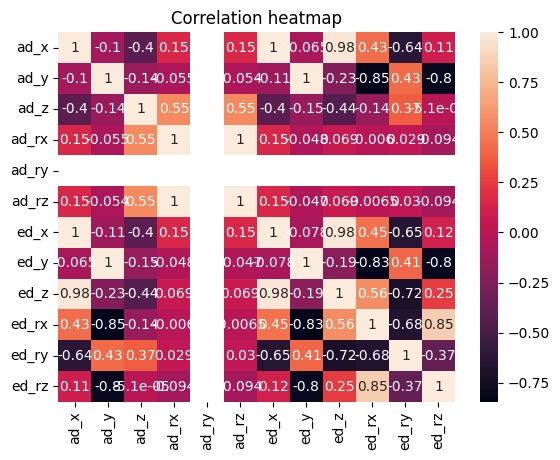

In [6]:
sns.heatmap(diff_df.iloc[:,:12].corr(),annot=True).set_title("Correlation heatmap")

## Multiple Linear Regression

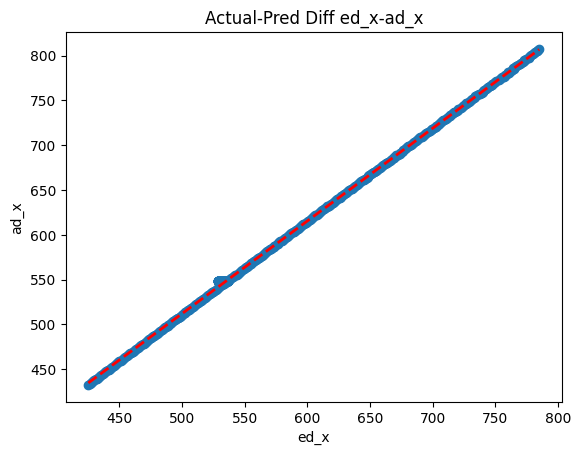

Regression Analysis for ed_x-ad_x:
R_squared:  0.9996072255410853
p-score:  0.0


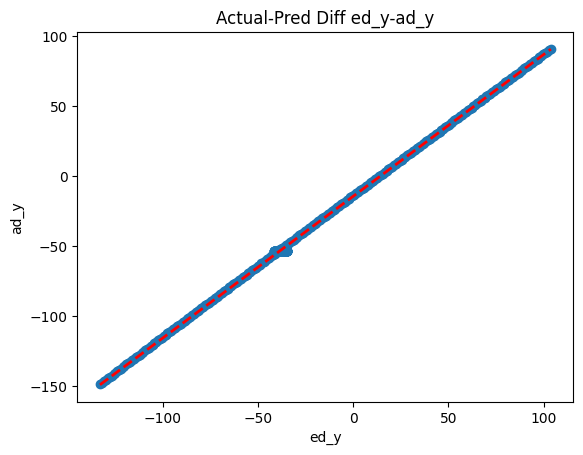

Regression Analysis for ed_y-ad_y:
R_squared:  0.9986812608590793
p-score:  0.0


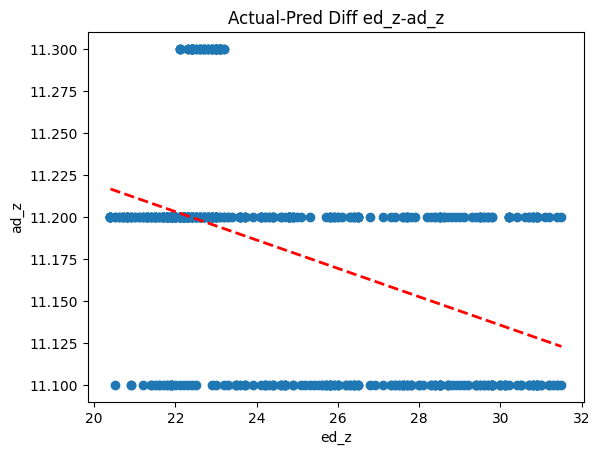

Regression Analysis for ed_z-ad_z:
R_squared:  0.19795880920132125
p-score:  2.785859308715774e-31


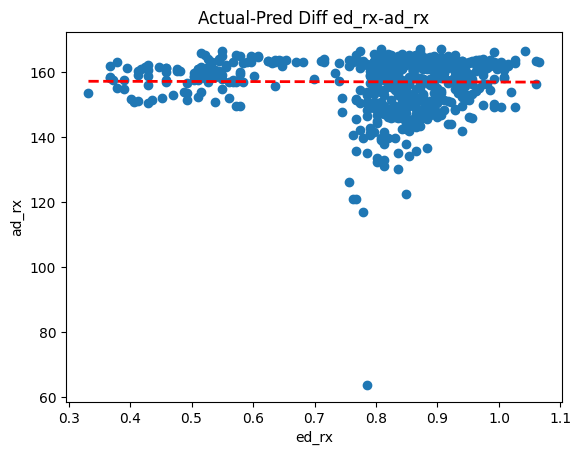

Regression Analysis for ed_rx-ad_rx:
R_squared:  3.6388590310965085e-05
p-score:  0.8812262513230256


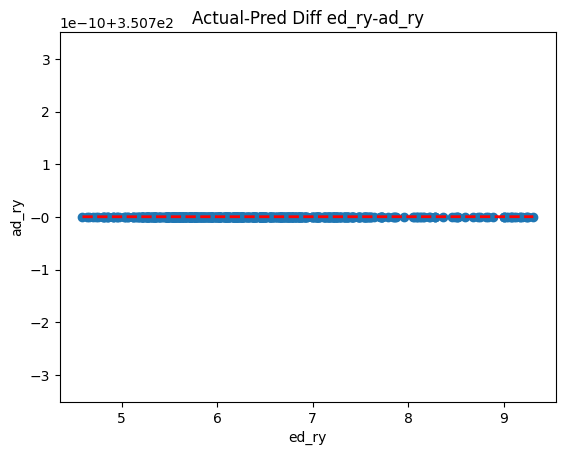

Regression Analysis for ed_ry-ad_ry:
R_squared:  -48.05681818181818
p-score:  1.0


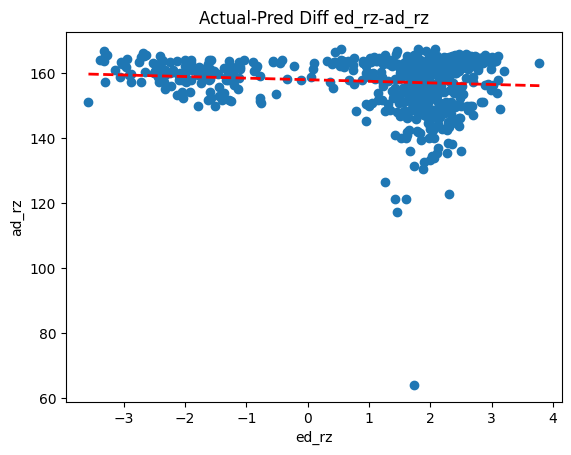

Regression Analysis for ed_rz-ad_rz:
R_squared:  0.008876242089931874
p-score:  0.01934682392484761


In [18]:
diff_name_list = [["ad_x", "ed_x"], ["ad_y", "ed_y"], ["ad_z", "ed_z"], ["ad_rx","ed_rx"],["ad_ry","ed_ry"],["ad_rz","ed_rz"]]

DEGREE = 1  # Degree of the polynomial features

coeff_dict = {}
for y,x in diff_name_list:
    X = diff_df[x].values.reshape(-1, 1)  # Predictor variable
    Y = diff_df[y]  # Response variable
    
    # Generate polynomial features
    poly_features = PolynomialFeatures(degree=DEGREE)
    X_poly = poly_features.fit_transform(X)
    
    # Perform polynomial regression using statsmodels
    sm_model = sm.OLS(Y, X_poly)
    sm_results = sm_model.fit()
    coeffs = sm_results.params
    coeff_dict[x] = coeffs
    
    # Predict using the polynomial regression model
    y_pred = sm_results.predict(X_poly)
    
    # Plot the data and the polynomial regression curve
    plt.scatter(X, Y)
    plt.title(f"Actual-Pred Diff {x}-{y}")
    plt.xlabel(x)
    plt.ylabel(y)
    
    # Sort the x values for better visualization
    sorted_indices = np.argsort(X, axis=0)
    x_sorted = X[sorted_indices].reshape(-1, 1)
    y_pred_sorted = y_pred[sorted_indices].reshape(-1, 1)
    
    # Plot the regression line
    plt.plot(x_sorted, y_pred_sorted, '--', color='red', linewidth=2)
    plt.show()
    
    # Print summary of regression analysis
    print(f"Regression Analysis for {x}-{y}:")
    print(f"R_squared: ",sm_results.rsquared)
    print(f"p-score: ",sm_results.f_pvalue)

In [19]:
coeff_dict

{'ed_x': const   -5.826689
 x1       1.035271
 dtype: float64,
 'ed_y': const   -14.394402
 x1        1.011941
 dtype: float64,
 'ed_z': const    11.388850
 x1       -0.008446
 dtype: float64,
 'ed_rx': const    157.405280
 x1        -0.346154
 dtype: float64,
 'ed_ry': const    3.507000e+02
 x1       1.665335e-14
 dtype: float64,
 'ed_rz': const    157.878833
 x1        -0.486624
 dtype: float64}